In [43]:
import re
import codecs
import pandas as pd
import numpy as np
from textblob import TextBlob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
import gensim
import multiprocessing
from scipy.interpolate import spline
import scipy
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from itertools import chain

%matplotlib inline

pd.options.display.float_format = '{:20,.2f}'.format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

In [42]:
def make_df(filename):
    # make list of chapters
    book = make_file(filename)
    
    # turn book into dataframe
    book_df = pd.DataFrame(book)
    book_df.columns = ['chapter_text']
    
    # add column with chapter's POV character
    book_df['chapter_name'] = book_df['chapter_text'].apply(chap_char)
    
    # remove chapter title from chapter_text
    book_df['chapter_text'] = book_df.apply(lambda row: row['chapter_text'][len(row['chapter_name']):], axis=1)
    
    # add column with book title
    title = book_df.ix[0, 1]
    book_df['book_title'] = title
    
    # drop first row with book basic info
    book_df.drop(0, inplace=True)
    
    # add column with chapter number
    book_df['chapter_num'] = book_df.index
    book_df = book_df[['book_title', 'chapter_num', 'chapter_name', 'chapter_text']]
    
    return book_df

    
def make_file(filename):
    # read in book text by line
    with codecs.open(filename, mode='r') as f:
        txt = f.read().splitlines()
    
    # concatinate lines in the same chapter
    book = []
    # initialize to false for first chapter
    end = False 
    
    for i in range(0, len(txt)):
        # remove page numbers and chapter headers
        txt[i] = re.sub('Page [0-9]*', '', txt[i])
        txt[i] = re.sub('Chapter [0-9]*', '', txt[i])
        
        # skip blank lines
        if not txt[i] or re.match("^ *$", txt[i]):
            continue
        
        # find chapter begining which start with character name capitalized
        elif re.match("^[ A-Z]*$", txt[i]):
            if end:
                # append previous chapter to list (false for first chapter)
                book.append(chapter) 
            # start new chapter
            chapter = txt[i]
            # set end to true for subsequent chapters after first chapter
            end = True
        
        # if not begining of chapter, add lines to chapter
        else:
            chapter = chapter + txt[i]
    book.append(chapter)
    return book


def chap_char(x):
    # Find character name in all caps
    name = re.findall(r'^[ A-Z]*', x)
    
    # clean name
    name = name[0]
    name = name[:-1]
    name = name.strip()
    if name[-2:] == ' A':
        name = name[:-2]
        name = name.strip() 
    return name


def sent_breakout(x, n):
    scores =[]
    for i in x:
        score = TextBlob(i).sentiment[n]
        scores.append(score)
    return scores


def sentiment_smooth(data, smooth=10):
    y = np.array(data)
    x = np.array(range(0, len(y)))

    x_smooth = np.linspace(x.min(), x.max(), smooth)
    
    groups = np.array_split(y, smooth)
    
    y_smooth = []
    for group in groups:
        y_smooth.append(group.mean())
    
    figure, ax = plt.subplots(figsize=(15, 5))
    plt.plot(x_smooth, y_smooth);
    d = np.zeros(len(y_smooth))
    ax.fill_between(x_smooth, y_smooth, where=y_smooth >= d, interpolate=True, color='yellow')
    ax.fill_between(x_smooth, y_smooth, where=y_smooth <= d, interpolate=True, color='red')
    plt.xlim(0, x.max())
    
    
def remove_stops(document):
    for i, x in enumerate(document):
        x = re.sub(r'[^a-zA-Z ]','', x)
        x = x.lower()
        document[i] = x.split()
    
    stoplist = stopwords.words('english') + ['ii']
    
    new_doc = [[word for word in sentence if word not in stoplist]
         for sentence in document]
    return new_doc


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % topic_idx
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])

In [3]:
# Make dataframe for each book
file1 = "GOTbooks/001ssb.txt"
file2 = "GOTbooks/002ssb.txt"
file3 = "GOTbooks/003ssb.txt"
file4 = "GOTbooks/004ssb.txt"
file5 = "GOTbooks/005ssb.txt"

game_of_thrones = make_df(file1)
clash_of_kings = make_df(file2)
storm_of_swords = make_df(file3)
feast_for_crows = make_df(file4)
dance_with_dragons = make_df(file5)


In [4]:
# Join books into one dataframe
book_names = [game_of_thrones, clash_of_kings, storm_of_swords, feast_for_crows, dance_with_dragons]
ice_and_fire = pd.concat(book_names)
ice_and_fire.reset_index(inplace=True, drop=True)

In [5]:
ice_and_fire.head()

,book_title,chapter_num,chapter_name,chapter_text
0,A GAME OF THRONES,1,PROLOGUE,"""We should start back,"" Gared urged as the wo..."
1,A GAME OF THRONES,2,BRAN,"The morning had dawned clear and cold, with a..."
2,A GAME OF THRONES,3,CATELYN,Catelyn had never liked this godswood. She ha...
3,A GAME OF THRONES,4,DAENERYS,Her brother held the gown up for her inspecti...
4,A GAME OF THRONES,5,EDDARD,The visitors poured through the castle gates ...


In [6]:
ice_and_fire.shape

(344, 4)

In [7]:
# Read in scraped Wiki data
with open('GOTscrapy/got_wiki.json') as filename:
    json_data = json.load(filename)

df = pd.DataFrame(json_data)
df

,book,chronology,pov,setting
0,A Game of Thrones,Prologue,Will,Haunted forest
1,A Game of Thrones,Bran I,Bran Stark,Winterfell
2,A Game of Thrones,Catelyn I,Catelyn Stark,Winterfell
3,A Game of Thrones,Daenerys I,Daenerys Targaryen,Pentos
4,A Game of Thrones,Eddard I,Eddard Stark,Winterfell
5,A Game of Thrones,Jon I,Jon Snow,Winterfell
6,A Game of Thrones,Catelyn II,Catelyn Stark,Winterfell
7,A Game of Thrones,Arya I,Arya Stark,Winterfell
8,A Game of Thrones,Bran II,Bran Stark,Winterfell
9,A Game of Thrones,Tyrion I,Tyrion Lannister,Winterfell


In [8]:
df.shape

(344, 4)

In [9]:
# Join book data and scraped data
ice_and_fire = ice_and_fire.join(df)

In [10]:
# Drop duplicate data and rearrange columns
ice_and_fire.drop(['book'], axis=1, inplace=True)
df_names = ['book_title', 'chapter_num', 'chapter_name', 'pov', 'chronology', 'setting', 'chapter_text']
ice_and_fire = ice_and_fire[df_names]
ice_and_fire.head()

,book_title,chapter_num,chapter_name,pov,chronology,setting,chapter_text
0,A GAME OF THRONES,1,PROLOGUE,Will,Prologue,Haunted forest,"""We should start back,"" Gared urged as the wo..."
1,A GAME OF THRONES,2,BRAN,Bran Stark,Bran I,Winterfell,"The morning had dawned clear and cold, with a..."
2,A GAME OF THRONES,3,CATELYN,Catelyn Stark,Catelyn I,Winterfell,Catelyn had never liked this godswood. She ha...
3,A GAME OF THRONES,4,DAENERYS,Daenerys Targaryen,Daenerys I,Pentos,Her brother held the gown up for her inspecti...
4,A GAME OF THRONES,5,EDDARD,Eddard Stark,Eddard I,Winterfell,The visitors poured through the castle gates ...


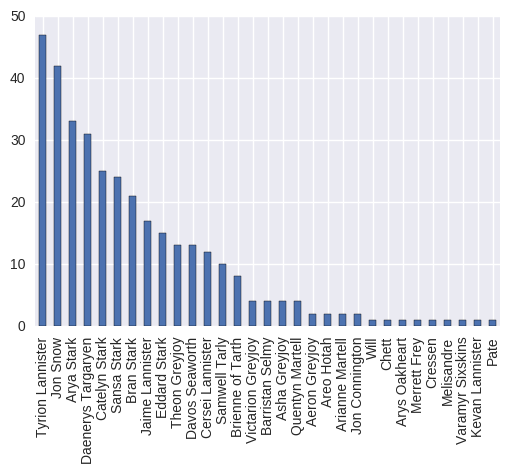

In [11]:
# POV character chapters
ice_and_fire.pov.value_counts().plot(kind='bar');

In [12]:
#ice_and_fire['polarity'] = ice_and_fire['chapter_text'].apply(lambda x: TextBlob(x).sentiment[0])
#ice_and_fire['subjectivity'] = ice_and_fire['chapter_text'].apply(lambda x: TextBlob(x).sentiment[1])

In [13]:
# Break up chapters into sentences
ice_and_fire['sentences'] = ice_and_fire.chapter_text.apply(sent_tokenize)

In [14]:
# Sentiment Analysis of sentences in each chapter
ice_and_fire['sentence_polarity'] = ice_and_fire['sentences'].apply(lambda x: sent_breakout(x, 0))
ice_and_fire['sentence_subjectivity'] = ice_and_fire['sentences'].apply(lambda x: sent_breakout(x, 1))
ice_and_fire.head()

,book_title,chapter_num,chapter_name,pov,chronology,setting,chapter_text,sentences,sentence_polarity,sentence_subjectivity
0,A GAME OF THRONES,1,PROLOGUE,Will,Prologue,Haunted forest,"""We should start back,"" Gared urged as the wo...","[ ""We should start back,"" Gared urged as the w...","[-0.075, -0.2, -0.2, 0.3, 0.0, -0.075, -0.2, -...","[0.2, 0.4, 0.4, 0.1, 0.0, 0.225, 0.4, 0.4, 0.4..."
1,A GAME OF THRONES,2,BRAN,Bran Stark,Bran I,Winterfell,"The morning had dawned clear and cold, with a...","[ The morning had dawned clear and cold, with ...","[-0.25, 0.0, 0.116666666667, 0.0, -0.125, 0.0,...","[0.691666666667, 0.0, 0.344444444444, 0.0, 0.2..."
2,A GAME OF THRONES,3,CATELYN,Catelyn Stark,Catelyn I,Winterfell,Catelyn had never liked this godswood. She ha...,"[ Catelyn had never liked this godswood., She ...","[-0.3, 0.05, 0.266666666667, 0.0, 0.1375, 0.0,...","[0.8, 0.5, 0.566666666667, 0.6, 0.3875, 0.0, 0..."
3,A GAME OF THRONES,4,DAENERYS,Daenerys Targaryen,Daenerys I,Pentos,Her brother held the gown up for her inspecti...,[ Her brother held the gown up for her inspect...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.1, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.35, 0.0,..."
4,A GAME OF THRONES,5,EDDARD,Eddard Stark,Eddard I,Winterfell,The visitors poured through the castle gates ...,[ The visitors poured through the castle gates...,"[0.433333333333, 0.15, 0.5, -0.15, -0.021875, ...","[0.733333333333, 0.25, 0.5, 0.9, 0.77222222222..."


In [15]:
# Total number of sentences across all books
count = 0
for x in ice_and_fire.sentences:
    a = len(x)
    count += a
    
count

158053

In [99]:
ice_and_fire.tail()

,book_title,chapter_num,chapter_name,pov,chronology,setting,chapter_text,sentences,sentence_polarity,sentence_subjectivity,sentences_stop
339,A DANCE WITH DRAGONS,69,THE DRAGONTAMER,Quentyn Martell,The Dragontamer,Meereen,The night crept past on slow black feet. The ...,"[ The night crept past on slow black feet., Th...","[-0.238888888889, 0.0, -0.1, -0.075, 0.35, 0.0...","[0.361111111111, 0.0, 0.4, 0.7, 0.65, 0.0, 0.2...","[[night, crept, past, slow, black, feet], [hou..."
340,A DANCE WITH DRAGONS,70,JON,Jon Snow,Jon XIII,Castle Black,"""Let them die,"" said Queen Selyse. It was the...","[ ""Let them die,"" said Queen Selyse., It was t...","[0.0, -0.1, 0.25, 0.0, 0.0, 0.5, -0.65, 0.0, 0...","[0.0, 0.4, 0.3, 0.0, 0.0, 0.5, 1.0, 0.0, 0.3, ...","[[let, die, said, queen, selyse], [answer, jon..."
341,A DANCE WITH DRAGONS,71,THE QUEENS HAND,Barristan Selmy,The Queen's Hand,Meereen,The Dornish prince was three days dying. He t...,"[ The Dornish prince was three days dying., He...","[0.0, -0.302777777778, -9.25185853854e-18, -0....","[0.0, 0.516666666667, 0.561111111111, 0.35, 0....","[[dornish, prince, three, days, dying], [took,..."
342,A DANCE WITH DRAGONS,72,DAENERYS,Daenerys Targaryen,Daenerys X,Dragonstone,The hill was a stony island in a sea of green...,[ The hill was a stony island in a sea of gree...,"[-0.2, -0.161111111111, 0.0, 0.0, -0.230769230...","[0.3, 0.227777777778, 0.0, 0.0, 0.461538461538...","[[hill, stony, island, sea, green], [took, dan..."
343,A DANCE WITH DRAGONS,73,EPILOGUE I,Kevan Lannister,Epilogue,King's Landing,"am no traitor,"" the Knight of Griffin's Roost...","[ am no traitor,"" the Knight of Griffin's Roos...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.5...","[0.0, 0.0, 0.5, 0.316666666667, 0.5, 0.0, 0.0,...","[[traitor, knight, griffins, roost, declared],..."


In [40]:
# Remove stop words from sentences
ice_and_fire['sentences_stop'] = deepcopy(ice_and_fire['sentences'])
ice_and_fire['sentences_stop'] = ice_and_fire['sentences_stop'].apply(remove_stops)

In [41]:
ice_and_fire.head()

,book_title,chapter_num,chapter_name,pov,chronology,setting,chapter_text,sentences,sentence_polarity,sentence_subjectivity,sentences_stop
0,A GAME OF THRONES,1,PROLOGUE,Will,Prologue,Haunted forest,"""We should start back,"" Gared urged as the wo...","[ ""We should start back,"" Gared urged as the w...","[-0.075, -0.2, -0.2, 0.3, 0.0, -0.075, -0.2, -...","[0.2, 0.4, 0.4, 0.1, 0.0, 0.225, 0.4, 0.4, 0.4...","[[start, back, gared, urged, woods, began, gro..."
1,A GAME OF THRONES,2,BRAN,Bran Stark,Bran I,Winterfell,"The morning had dawned clear and cold, with a...","[ The morning had dawned clear and cold, with ...","[-0.25, 0.0, 0.116666666667, 0.0, -0.125, 0.0,...","[0.691666666667, 0.0, 0.344444444444, 0.0, 0.2...","[[morning, dawned, clear, cold, crispness, hin..."
2,A GAME OF THRONES,3,CATELYN,Catelyn Stark,Catelyn I,Winterfell,Catelyn had never liked this godswood. She ha...,"[ Catelyn had never liked this godswood., She ...","[-0.3, 0.05, 0.266666666667, 0.0, 0.1375, 0.0,...","[0.8, 0.5, 0.566666666667, 0.6, 0.3875, 0.0, 0...","[[catelyn, never, liked, godswood], [born, tul..."
3,A GAME OF THRONES,4,DAENERYS,Daenerys Targaryen,Daenerys I,Pentos,Her brother held the gown up for her inspecti...,[ Her brother held the gown up for her inspect...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.1, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.35, 0.0,...","[[brother, held, gown, inspection], [beauty], ..."
4,A GAME OF THRONES,5,EDDARD,Eddard Stark,Eddard I,Winterfell,The visitors poured through the castle gates ...,[ The visitors poured through the castle gates...,"[0.433333333333, 0.15, 0.5, -0.15, -0.021875, ...","[0.733333333333, 0.25, 0.5, 0.9, 0.77222222222...","[[visitors, poured, castle, gates, river, gold..."


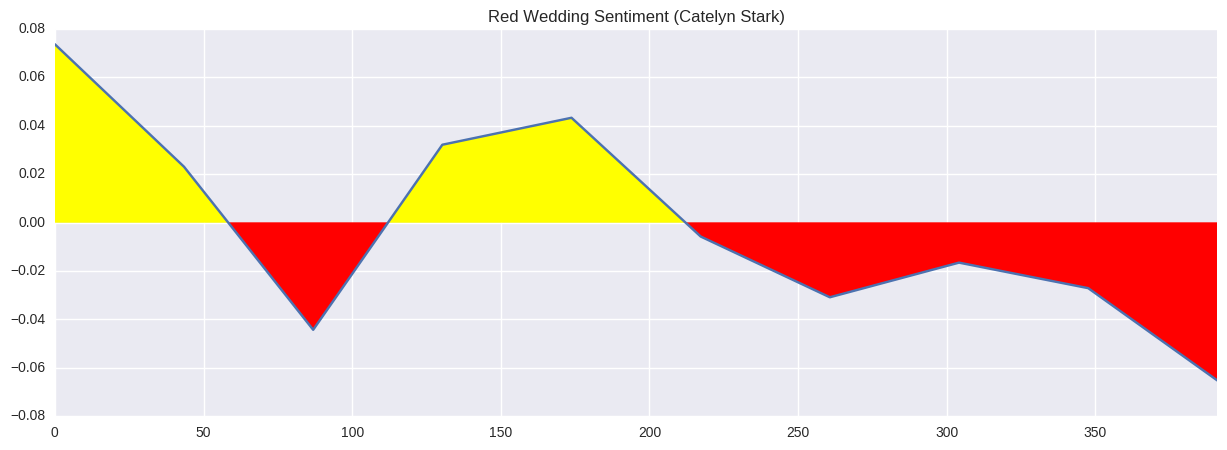

In [92]:
# Red Wedding sentiment 
sentiment_smooth(ice_and_fire.ix[194, 8], smooth=10)
plt.title('Red Wedding Sentiment (Catelyn Stark)');

In [33]:
cersei_chap = ice_and_fire.sentence_polarity[ice_and_fire.pov == "Cersei Lannister"]
cersei_chap

228    [0.08, 0.7, 0.8, 0.219444444444, 0.0, -0.4, 0....
232    [-0.25, -0.2, 0.0, 0.0, 0.0, 0.0, 0.35, -0.35,...
237    [0.0, 0.2, 0.1, 0.0, 0.0, -0.1875, 0.0, -0.1, ...
242    [0.0, 0.0, 0.0, -0.125, 0.0, 0.0, 0.0, -0.5, 0...
249    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10714285...
253    [0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.136363636364,...
257    [0.0, -0.1875, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, ...
261    [-0.25, 0.0, 0.0, -0.0625, -0.05, 0.3041666666...
264    [0.04, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1,...
268    [-0.125, -0.252976190476, 0.16, 0.0, 0.05, 0.1...
325    [0.0, 0.0, 0.104047619048, 0.17, -0.1555555555...
336    [0.0, 0.15, 0.0, 0.0, 0.0, 0.18, -0.6, -0.0766...
Name: sentence_polarity, dtype: object

In [34]:
cersei = []
for chapter in cersei_chap:
    cersei += chapter

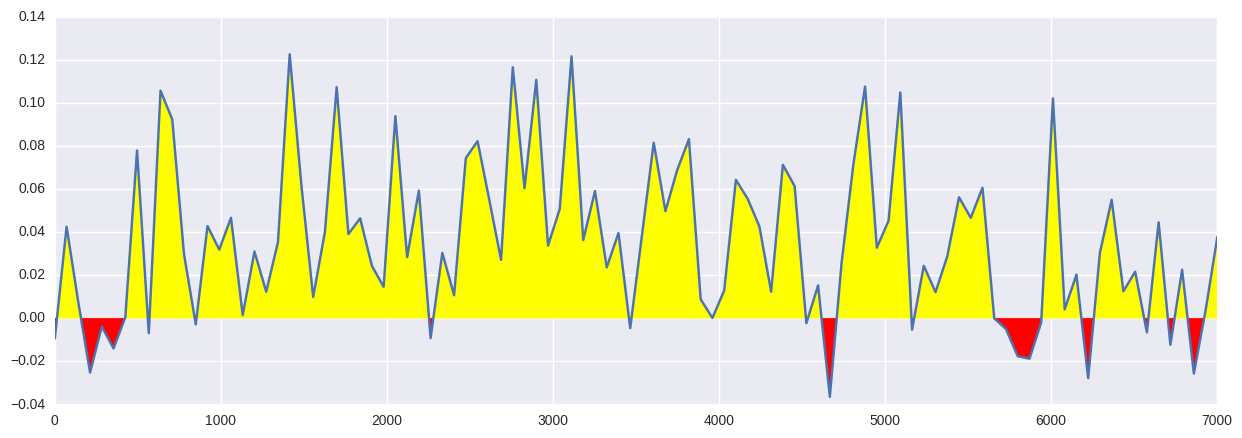

In [98]:
sentiment_smooth(cersei, smooth=100)

In [55]:
males = [
    'Tyrion Lannister', 
    'Jon Snow', 
    'Bran Stark', 
    'Jaime Lannister', 
    'Eddard Stark', 
    'Theon Greyjoy', 
    'Davos Seaworth',
    'Samwell Taryl',
    'Victarion Greyjoy',
    'Barristan Selmy',
    'Quentyn Martell',
    'Aeron Greyjoy',
    'Areo Hotah',
    'Jon Connington',
    'Will',
    'Chet',
    'Arys Oakheart',
    'Merrett Frey',
    'Cressen',
    'Varamyr Sixskins',
    'Kevan Lannister',
    'Pate'
    
]

females = [
    'Arya Stark', 
    'Daenerys Targaryen', 
    'Catelyn Stark', 
    'Sansa Stark',
    'Cersei Lannister',
    'Brienne of Tarth',
    'Asha Greyjoy',
    'Arianne Martell',
    'Melisandre'
]

male_chaps = ice_and_fire.loc[ice_and_fire['pov'].isin(males)]
print len(male_chaps)

female_chaps = ice_and_fire.loc[ice_and_fire['pov'].isin(females)]
print len(female_chaps)

193
140


In [114]:
data_samples = list(chain.from_iterable(female_chaps.ix[:, 7]))
data_samples[0:5]

[' Catelyn had never liked this godswood.',
 'She had been born a Tully, at Riverrun far to the south, on the Red Fork of the Trident.',
 'The godswood there was a garden, bright and airy, where tall redwoods spread dappled shadows across tinkling streams, birds sang from hidden nests, and the air was spicy with the scent of flowers.',
 'The gods of Winterfell kept a different sort of wood.',
 'It was a dark, primal place, three acres of old forest untouched for ten thousand years as the gloomy castle rose around it.']

In [122]:
n_topics = 12
n_top_words = 5

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(data_samples)

nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

#Countvectorizer/lda

Topic #0:
said dany catelyn robb yes
Topic #1:
did understand hear answer think
Topic #2:
know don does wanted didn
Topic #3:
lord father tywin beric walder
Topic #4:
ser jorah barristan loras rodrik
Topic #5:
lady mother lysa catelyn sansa
Topic #6:
asked dany brienne catelyn podrick
Topic #7:
told thought arya man king
Topic #8:
grace good green kind yes
Topic #9:
come ll harm way let
Topic #10:
want don ll does hear
Topic #11:
say heard word kind words


In [121]:
tfidf.shape

(64590, 16679)

In [87]:
# combine all books to one string
all_books = ""
for x in ice_and_fire.chapter_text:
    all_books = all_books + x

# tokenize sentences
all_books = sent_tokenize(all_books)

all_books = remove_stops(all_books)

"# remove punctuation\nfor i, x in enumerate(all_books):\n    x = re.sub(r'[^a-zA-Z ]','', x)\n    x.lower()\n    all_books[i] = x.split()"

In [ ]:
'''# combine all books to one string
all_books = ""
files = [
    'GOTbooks/game_of_thrones.txt', 
    'GOTbooks/storm_of_swords.txt', 
    'GOTbooks/clash_of_kings.txt', 
    'GOTbooks/feast_for_crows.txt', 
    'GOTbooks/dance_with_dragons.txt']

for doc in files:
    with open(doc, 'r') as f:
        f = f.read()
    all_books = all_books + f
'''

In [90]:
token_count = sum([len(sentence) for sentence in all_books])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 893,760 tokens


In [91]:
# "We should start back," Gared urged as the woods began to grow dark around them.
all_books[0]

['start', 'back', 'gared', 'urged', 'woods', 'began', 'grow', 'dark', 'around']

In [107]:
num_features = 100
context_size = 7
min_word_count = 3
num_workers = multiprocessing.cpu_count()


thrones2vec = gensim.models.Word2Vec(
    all_books, 
    size=num_features, 
    window=context_size, 
    min_count=min_word_count, 
    workers=num_workers,
    sg=1
)

In [108]:
thrones2vec.most_similar('king')

[('baratheon', 0.7214060425758362),
 ('aerys', 0.6967325806617737),
 ('usurper', 0.6909040212631226),
 ('jaehaerys', 0.6682711839675903),
 ('traitor', 0.6539040207862854),
 ('declare', 0.651328444480896),
 ('realm', 0.6465470790863037),
 ('roberts', 0.6433359980583191),
 ('rebellion', 0.642902672290802),
 ('treason', 0.6393932104110718)]

In [109]:
thrones2vec.most_similar("stark")

[('starks', 0.7946773171424866),
 ('lyanna', 0.7247304916381836),
 ('torrhen', 0.7185643911361694),
 ('eddard', 0.7156428694725037),
 ('brandon', 0.705174446105957),
 ('alys', 0.7041792869567871),
 ('eddards', 0.7038537263870239),
 ('tullys', 0.6977410316467285),
 ('robb', 0.6939102411270142),
 ('foster', 0.6890273094177246)]

In [110]:
thrones2vec.most_similar("direwolf")

[('ghost', 0.7772939205169678),
 ('pup', 0.7622764706611633),
 ('direwolves', 0.7435413599014282),
 ('wolf', 0.721743106842041),
 ('padding', 0.7214123010635376),
 ('shaggydog', 0.7178492546081543),
 ('icewhite', 0.7178453803062439),
 ('wight', 0.7173025608062744),
 ('robb', 0.7166509628295898),
 ('orell', 0.7136993408203125)]

In [111]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))

nearest_similarity_cosmul("stark", "winterfell", "riverrun")
nearest_similarity_cosmul("jaime", "sword", "wine")
nearest_similarity_cosmul("arya", "nymeria", "dragons")

stark is related to winterfell, as tully is related to riverrun
jaime is related to sword, as drank is related to wine
arya is related to nymeria, as dany is related to dragons
theon is related to reek, as frail is related to blind


In [120]:
thrones2vec.most_similar("dorne")

[('sunspear', 0.8818882703781128),
 ('trystane', 0.8616500496864319),
 ('lawful', 0.8429874181747437),
 ('rhaegars', 0.8310557007789612),
 ('dorans', 0.8299638628959656),
 ('stormborn', 0.825019896030426),
 ('myrcella', 0.8209385275840759),
 ('gulltown', 0.8175390958786011),
 ('consented', 0.8150091767311096),
 ('reign', 0.8104502558708191)]